In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import Image

In [2]:
bs = 128
epochs = 10

In [3]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [4]:
def flatten(x):
    return to_var(x.view(x.size(0), -1))

In [5]:
def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

In [7]:
# Load Data
dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 23993704.94it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 301867.92it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 6915281.15it/s]                            
8192it [00:00, 141734.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


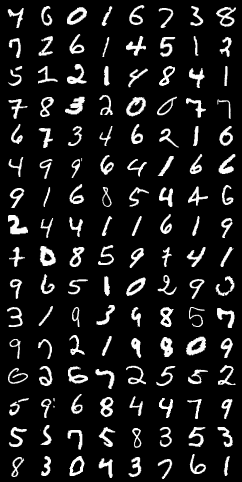

In [8]:
# Fixed input for debugging
fixed_x, _ = next(iter(data_loader))
save_image(fixed_x)
fixed_x = flatten(fixed_x)

Image('real_image.png')

In [9]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [10]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [11]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [12]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [13]:
epochs = 10

In [18]:
loss.item()

66473.1953125

In [19]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(data_loader):
        images = flatten(images)
        recon_images, mu, logvar = vae(images)
        loss = loss_fn(recon_images, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))
    
            recon_x, _, _ = vae(fixed_x)
            save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'reconstructed/recon_image_{epoch}_{idx}.png')

Epoch[1/10] Loss: 492.313


FileNotFoundError: [Errno 2] No such file or directory: 'reconstructed/recon_image_0_0.png'

In [15]:
sample = Variable(torch.randn(128, 20))
recon_x = vae.decoder(sample)
# recon_x, _, _ = vae(fixed_x)

save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), 'sample_image.png')
Image('sample_image.png')

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #4 'mat1'

In [ ]:
images = []
for file in sorted([file for file in Path('reconstructed').glob('*.png')]):
    images.append(imageio.imread(file))
imageio.mimsave('recon_image.gif', images)
Image(filename="recon_image.gif")